# SIR model

Thesis entitled *The Metropolis-Hastings Algorithm: Inverse Problems, Model Calibration, and the TOMGRO Model*


Notebook done by **Carlos Nosa**. 




We are going to use the following packages:

In [ ]:
using Plots
using Distributions
using LinearAlgebra

[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]


**Problem Statement:** Estimate the basic reproduction number $\mathcal{R}_0$ of the Spanish flu in San Francisco in the year 1918.


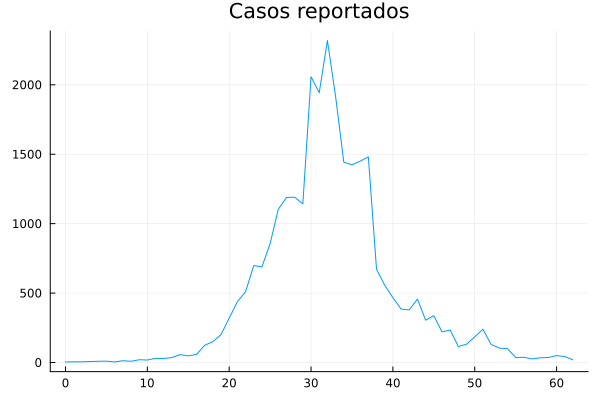

In [2]:
Data = [0 4; 1 5; 2 5; 3 7; 4 9; 5 10; 6 4; 7 13; 8 9; 9 20; 10 18; 
        11 30; 12 29; 13 36; 14 57; 15 48; 16 58; 17 124; 18 150; 19 201; 20 320; 
        21 438; 22 510; 23 698; 24 689; 25 856; 26 1104; 27 1189; 28 1190; 29 1143; 30 2058; 
        31 1943; 32 2319; 33 1916; 34 1443; 35 1424; 36 1450; 37 1481; 38 672; 39 557; 40 467; 
        41 385; 42 379; 43 457; 44 305; 45 337; 46 221; 47 234; 48 115; 49 132; 50 185; 
        51 240; 52 130; 53 104; 54 100; 55 36; 56 38; 57 26; 58 34; 59 36; 60 50; 
        61 43; 62 19]

Time = Data[:,1]
Cases = Data[:,2]
plot(Time,Cases, label=false, title="Casos reportados")

In [3]:
function MetEuler(f, p, y0, t0, tn, h)
    # f: función que define la EDO dy/dt = f(t, y; p)
    # y0: condición inicial
    # t0: tiempo inicial
    # tn: tiempo final
    # h: tamaño del paso
    # p: parámetros de la función f

    # Número de pasos
    n_steps = Int((tn - t0) / h)

    #Dimensión de y0
    d = size(y0)[1]
    
    t_values = zeros(n_steps + 1)
    y_values = zeros(d,n_steps + 1)

    # Acondiciones iniciales
    t_values[1] = t0
    y_values[:,1] = y0

    # Método de Euler
    for i in 1:n_steps
        t_values[i + 1] = t_values[i] + h
        y_values[:,i + 1] = y_values[:,i] + h * f(t_values[i], y_values[:,i],p)
    end

    return t_values, y_values
end

MetEuler (generic function with 1 method)

**Modelo matemático de la influenza**
En este cuaderno se modela el comportamiento de la gripe española en San Francisco de 1918 a 1919.
$$
\begin{align*}
 \dot{S} &= \mu N - \beta \frac{I}{N}S - \xi S - \mu S \\
 \dot{I} &= \beta \frac{I}{N}S + \xi S - \gamma  I - \mu I\\
 \dot{R} &= \gamma I - \mu R
\end{align*}
$$
donde $N = S + I + R$ y $\dot{N} = 0$. Los parámetros $\mu,\xi, N$ y $\gamma$ son conocidos. Con el modelo anteriormente mencionado se quiere hallar el número de reproducción $\mathcal{R}$ y los parámetros $\beta, I(0)$ y $R(0)$.

In [51]:
#Valores inciales
mu = 1.0 / (75.0 * 365.0)
xi = 10^(-5)
N = 550000.0
sigma = 1.0 / 3.0
gamma = 1.0 / 5.0
Pobs = 0.75
beta0 = 1.8 * (sigma + mu) * (gamma + mu) / sigma ;

In [147]:
function rhs(t,x,p)
    # Parámetros
    beta = p[1]/100
    # Variables
    S = x[1]
    I = x[2]
    R = x[3]
    # Ecuaciones 
    St = mu*N - beta*I*S/N - xi*S-mu*S
    It = beta*I*S/N + xi*S - gamma*I- mu*I
    Rt = gamma*I - mu*R
    return [St,It,Rt]
end

function support(p)
    rt = true
    rt &= (0.0 < p[1] < 100.0)
    rt &= (0.0 < p[2] < 100.0)
    rt &= (0.0 < p[3] < 100.0)
    rt &= (0.0 < p[4] < 100.0)
    rt &= (0.0 < p[5] < 100.0)
    rt &= (p[2] + p[3] + p[4] <= 100.0)
    return rt
end 

function init()
    p = rand(Uniform(0,100),5)
    sum = p[2] + p[3] + p[4]
    p[2] = 100 * p[2]/sum
    p[3] = 100 * p[3]/sum
    p[4] = 100 * p[4]/sum
    return p
end

function sol_num(p)
    # Parámetros
    beta = p[1]/100
    S0 = N*p[2]/100
    I0 = N*p[3]/100
    R0 = N*p[4]/100
    return MetEuler(rhs, p, [S0,I0,R0], 0, 62, 0.1)
end

function meanglm(p)
    # Parámetros
    beta = p[1]/100
    k = p[5]/100
    result = zeros(62)
    weights = ones(Int(1/0.1) + 1)
    weights[1] = 0.5
    weights[end] = 0.5
    
    T, SIR = sol_num(p)
    A = zeros(Int(1/0.1) + 1,62,3)
    for k=0:62-1
        A[:,k+1,1] = SIR[1,:][10*k+1:Int(1/0.1)+10*k+1]
        A[:,k+1,2] = SIR[2,:][10*k+1:Int(1/0.1)+10*k+1]
        A[:,k+1,3] = SIR[3,:][10*k+1:Int(1/0.1)+10*k+1]
    end

    for j=1:62
        result[j] = (0.1)*dot(weights, (beta) * A[:,j,1]/N .* A[:,j,2] .+ xi*A[:,j,1]  )    
    end 
    return k*result
end

meanglm (generic function with 1 method)

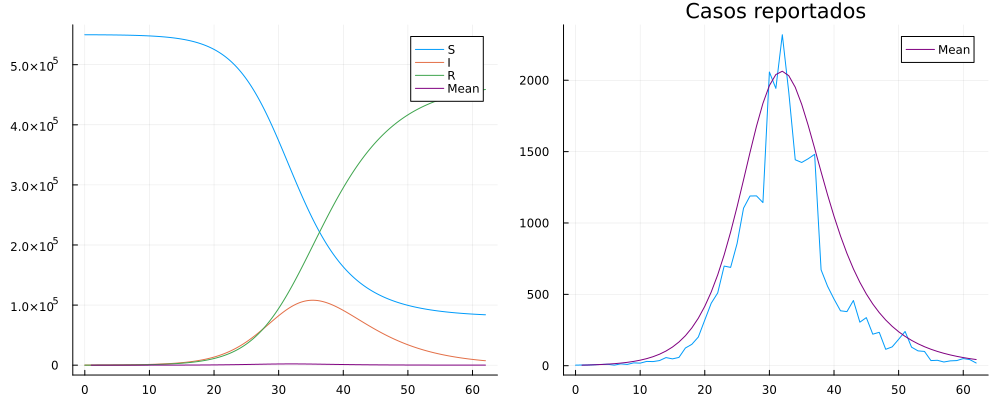

In [157]:
par = [45,99.985,0.015,0.00,8]
T, SIR = sol_num(par)
p1 = plot(T,SIR[1,:],label="S")
p1 = plot!(T,SIR[2,:],label="I")
p1 = plot!(T,SIR[3,:],label="R")
p1 = plot!(meanglm(par),label="Mean",color="purple")

p2 = plot(Time,Cases, label=false, title="Casos reportados")
p2 = plot!(meanglm(par),label="Mean",color="purple")
plot(p1,p2,layout=(1,2),size=(1000,400))

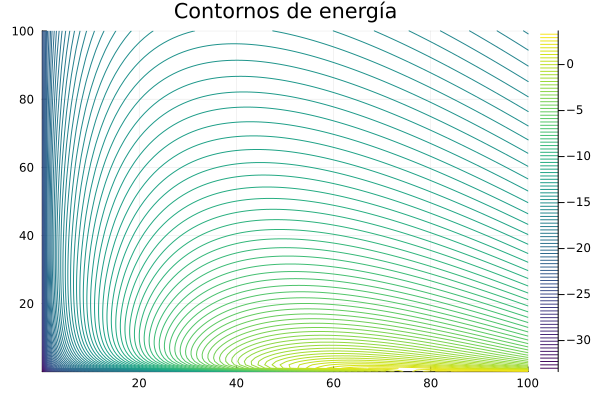

In [195]:
function energy(p)
    # Parámetros
    mu = meanglm(p)

    # poisson
    log_likelihood = sum(logpdf.(Poisson.(mu), Cases[2:end]))
    log_prior = 0
    log_prior += logpdf(Normal(45,1), p[1])  
    log_prior += logpdf(Normal(95,1), p[2])  
    log_prior += logpdf(Normal(3,1), p[3])
    log_prior += logpdf(Normal(2,1), p[4])
    log_prior += logpdf(Normal(8,1), p[5])
    
    return log_likelihood*(10^(-4)) + log_prior*(10^(-4)) + log(50)
end

g(x, y) = energy((45,x,y,0,8))

x_range = 0.05:1:100.05
y_range = 0.05:1:100.05

# Inicializar matrices para la malla
mesh_x = zeros(length(x_range), length(y_range))
mesh_y = zeros(length(x_range), length(y_range))
# Llenar las matrices de la malla con valores de x e y
for i in 1:length(x_range)
    for j in 1:length(y_range)
        mesh_x[i, j] = x_range[i]
        mesh_y[i, j] = y_range[j]
    end
end
# Evaluar la función en cada punto de la malla
z_values = g.(mesh_y, mesh_x)
# Crear el gráfico de contornos
contour(x_range, y_range, z_values, levels=100, color=:viridis, title="Contornos de energía")

In [191]:
# Número de iteraciones
iterations = 10000
# Punto inicial 
samplesSIR = zeros(5,1)
samplesSIR[:,1] = init()

probabilitiesSIR = [exp(energy(samplesSIR[:,end]))] # energía

Alpha = [0] # tasa de aceptación
sd = 2 # desviación estándar del camino aleatorio

# MHRW
for i in 1:iterations
    # Construcción de nuevas muestras con un camino aleatorio normal
    theta = samplesSIR[:,end]+ sd*randn(5)

    # Condición del soporte
    if support(theta) == false
        alpha = 0
        p2 = exp(energy(samplesSIR[:,end]))
    else
        p1 = exp(energy(theta))
        p2 = exp(energy(samplesSIR[:,end]))
        alpha = min(1, p1/p2)
    end 
    
    Alpha = hcat(Alpha,alpha)
    u = rand()

    #Selección de muestras
    if u < alpha
        samplesSIR = hcat(samplesSIR, theta)
        probabilitiesSIR = hcat(probabilitiesSIR,p1)
    else
        samplesSIR = hcat(samplesSIR, samplesSIR[:,end])
        probabilitiesSIR = hcat(probabilitiesSIR,p2)
    end
end



initial_position = floor(100*rand())
leap = 20
samplesSIR_ss = samplesSIR[:, Int(initial_position):leap:end]
probabilitiesSIR_ss = probabilitiesSIR[Int(initial_position):leap:end];

max_probSIR, positionSIR_ss = findmax(probabilitiesSIR_ss)
Max_likelihoodSIR = samplesSIR_ss[:, positionSIR_ss]
MeanSIR = mean(samplesSIR_ss, dims=2)

@show exp(max_probSIR)
@show Max_likelihoodSIR
@show MeanSIR;

exp(max_probSIR) = 2.0798478686106066e14
Max_likelihoodSIR = [64.47628903641873, 66.63182396394177, 0.045008667942102176, 8.54442318998797, 9.520160119471186]
MeanSIR = [68.95998817807512; 41.41166686718359; 1.3807184630971654; 27.70805608415153; 38.33160431178359;;]


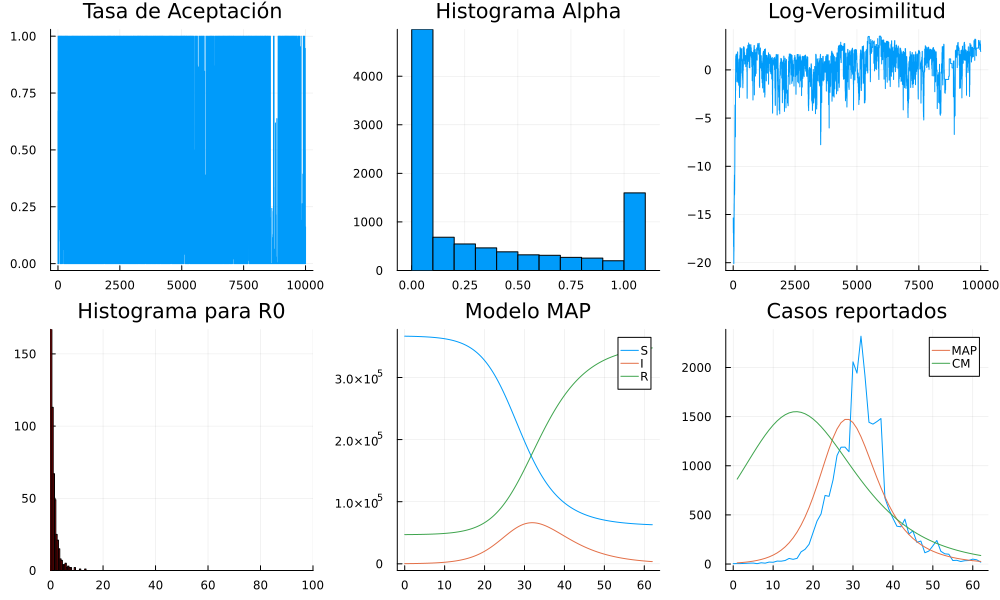

In [192]:
p01 = plot(Alpha[1,:],title="Tasa de Aceptación",label=false)
p02 = histogram(Alpha[1,:],title="Histograma Alpha",label=false)
p03 = plot(log.(probabilitiesSIR[1,:]),title="Log-Verosimilitud",label=false)
p04 = histogram(samplesSIR_ss[3,:],bins=50,label=false,color="red",xlim=(0,100),title="Histograma para R0")
T, SIR = sol_num(Max_likelihoodSIR)
p05 = plot(T,SIR[1,:],label="S",title="Modelo MAP")
p05 = plot!(T,SIR[2,:],label="I")
p05 = plot!(T,SIR[3,:],label="R")
p06 = plot(Time,Cases, label=false, title="Casos reportados")
p06 = plot!(meanglm(Max_likelihoodSIR),label="MAP")
p06 = plot!(meanglm(MeanSIR),label="CM")
plot(p01,p02,p03,p04,p05,p06,layout=(2,3),size=(1000,600))